In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader
import tonic
import tonic.transforms as transforms

c:\Users\mahia\miniconda3\envs\thesis\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
N_FRAMES = 60  # you can try 30/60/80 later

frame_transform = transforms.ToFrame(
    sensor_size=tonic.datasets.DVSGesture.sensor_size,
    n_time_bins=N_FRAMES  # <-- fixed T instead of time_window
)

In [ ]:
# Load dataset
train_dataset = tonic.datasets.DVSGesture(save_to='../newdata', train=True, transform=frame_transform)
test_dataset  = tonic.datasets.DVSGesture(save_to='../newdata', train=False, transform=frame_transform)

In [6]:
# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [7]:
print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

Train samples: 1077, Test samples: 264


In [8]:
frames, labels = next(iter(train_loader))
print("Frames shape:", frames.shape)  # Expected: (batch, T, 2, 128, 128)
print("Labels:", labels)

Frames shape: torch.Size([8, 60, 2, 128, 128])
Labels: tensor([9, 8, 2, 7, 8, 4, 2, 0])


In [9]:
frames = frames.permute(0, 2, 1, 3, 4)  # (B, 2, T, 128, 128)

In [10]:
frames, labels = next(iter(train_loader))
print(frames.dtype)   # You’ll likely see torch.int16 or torch.uint8

torch.int16


In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
class Gesture3DCNN(nn.Module):
    def __init__(self, num_classes=11):
        super().__init__()
        self.conv1 = nn.Conv3d(2, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm3d(32)
        self.pool1 = nn.MaxPool3d((1, 2, 2))

        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm3d(64)
        self.pool2 = nn.MaxPool3d((2, 2, 2))

        self.conv3 = nn.Conv3d(64, 128, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm3d(128)
        self.pool3 = nn.MaxPool3d((2, 2, 2))

        self.dropout = nn.Dropout(p=0.3)
        self.gap = nn.AdaptiveAvgPool3d((1, 4, 4))
        self.fc  = nn.Linear(128 * 1 * 4 * 4, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x)

In [13]:
# Reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

model = Gesture3DCNN(num_classes=11).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  # weight decay helps generalization
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2
)

scaler = GradScaler(enabled=torch.cuda.is_available())

C:\Users\mahia\AppData\Local\Temp\ipykernel_138320\647378252.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=torch.cuda.is_available())


In [34]:
EPOCHS = 20
history = {'train_loss': [], 'train_acc': [], 'test_acc': []}

def evaluate_accuracy(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for frames, labels in loader:
            frames = frames.permute(0, 2, 1, 3, 4).float().to(device)
            max_vals = frames.amax(dim=(2, 3, 4), keepdim=True)
            frames = frames / (max_vals + 1e-6)
            labels = labels.to(device)
            logits = model(frames)
            correct += (logits.argmax(1) == labels).sum().item()
            total += labels.size(0)
    return correct / total

best_acc, best_state = 0.0, None
patience, waited = 5, 0  # early stopping

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for frames, labels in train_loader:
        frames = frames.permute(0, 2, 1, 3, 4).float().to(device)
        max_vals = frames.amax(dim=(2, 3, 4), keepdim=True)
        frames = frames / (max_vals + 1e-6)
        labels = labels.to(device)

        optimizer.zero_grad()
        with autocast(enabled=torch.cuda.is_available()):
            logits = model(frames)
            loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * frames.size(0)
        correct += (logits.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc  = correct / total
    test_acc   = evaluate_accuracy(model, test_loader)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_acc'].append(test_acc)

    # LR schedule on validation metric
    scheduler.step(test_acc)

    # Save best and early stop
    if test_acc > best_acc:
        best_acc = test_acc
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        waited = 0
        torch.save({'state_dict': best_state, 'acc': best_acc}, 'best_dvsgesture_3dcnn.pth')
    else:
        waited += 1

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.3f} | Test Acc: {test_acc:.3f} | LR: {optimizer.param_groups[0]['lr']:.1e}")

    if waited >= patience:
        print(f"Early stopping triggered. Best Test Acc: {best_acc:.3f}")
        break

# Restore best weights
if best_state is not None:
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

C:\Users\mahia\AppData\Local\Temp\ipykernel_27012\1697147677.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


Epoch 01 | Train Loss: 1.2844 | Train Acc: 0.517 | Test Acc: 0.697 | LR: 1.0e-03
Epoch 02 | Train Loss: 0.7699 | Train Acc: 0.724 | Test Acc: 0.746 | LR: 1.0e-03
Epoch 03 | Train Loss: 0.5042 | Train Acc: 0.837 | Test Acc: 0.814 | LR: 1.0e-03
Epoch 04 | Train Loss: 0.3819 | Train Acc: 0.881 | Test Acc: 0.773 | LR: 1.0e-03
Epoch 05 | Train Loss: 0.3379 | Train Acc: 0.896 | Test Acc: 0.875 | LR: 1.0e-03
Epoch 06 | Train Loss: 0.2736 | Train Acc: 0.907 | Test Acc: 0.841 | LR: 1.0e-03
Epoch 07 | Train Loss: 0.2424 | Train Acc: 0.931 | Test Acc: 0.909 | LR: 1.0e-03
Epoch 08 | Train Loss: 0.1836 | Train Acc: 0.938 | Test Acc: 0.875 | LR: 1.0e-03
Epoch 09 | Train Loss: 0.2063 | Train Acc: 0.938 | Test Acc: 0.879 | LR: 1.0e-03
Epoch 10 | Train Loss: 0.1675 | Train Acc: 0.952 | Test Acc: 0.898 | LR: 5.0e-04
Epoch 11 | Train Loss: 0.1185 | Train Acc: 0.970 | Test Acc: 0.909 | LR: 5.0e-04
Epoch 12 | Train Loss: 0.0940 | Train Acc: 0.975 | Test Acc: 0.879 | LR: 5.0e-04
Early stopping triggered. Be

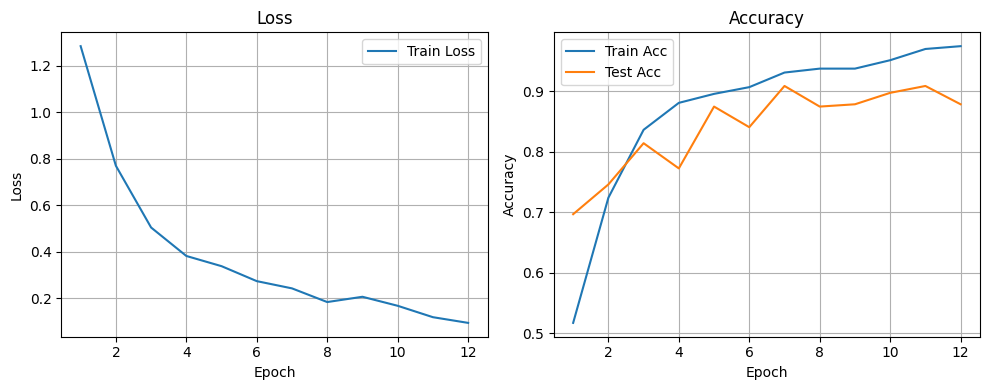

In [35]:
import matplotlib.pyplot as plt

epochs = range(1, len(history['train_loss']) + 1)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss'); plt.grid(True); plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, history['train_acc'], label='Train Acc')
plt.plot(epochs, history['test_acc'], label='Test Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy'); plt.grid(True); plt.legend()

plt.tight_layout(); plt.show()

In [36]:
model.eval()
with torch.no_grad():
    sample_frames, sample_label = test_dataset[0]  # (T, 2, 128, 128), int label
    x = torch.tensor(sample_frames).unsqueeze(0)   # (1, T, 2, H, W)
    x = x.permute(0, 2, 1, 3, 4).float().to(device)
    x = x / (x.amax(dim=(2,3,4), keepdim=True) + 1e-6)
    logits = model(x)
    pred = logits.argmax(1).item()
print("True label:", sample_label, "Predicted:", pred)

True label: 0 Predicted: 0


In [37]:
# Classification report
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.78      0.88      0.82        24
           1       1.00      1.00      1.00        24
           2       1.00      1.00      1.00        24
           3       1.00      0.29      0.45        24
           4       0.83      1.00      0.91        24
           5       0.96      1.00      0.98        24
           6       0.92      1.00      0.96        24
           7       0.95      0.75      0.84        24
           8       0.74      0.58      0.65        24
           9       1.00      0.46      0.63        24
          10       0.45      1.00      0.62        24

    accuracy                           0.81       264
   macro avg       0.88      0.81      0.81       264
weighted avg       0.88      0.81      0.81       264

